# [George McNinch](http://gmcninch.math.tufts.edu) Math 87 - Spring 2025


# Integer programming via Branch & Bound
# Week 5


Integer programming: summary of some issue(s)
---------------------------------------------


As an example, consider the linear program:

``maximize`` $f(x_1,x_2) = x_1 + 5x_2$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$.

Let's find the optimal solution $\mathbf{x} \in \mathbb{R}^2$, and the optimal *integral* solution
$\mathbf{x}$ with $x_1,x_2 \in \mathbb{Z}$.

We'll start by solving the *relaxed* problem, where the integrality condition is ignored:

In [1]:
from scipy.optimize import linprog
import numpy as np

A = np.array([[1,10],[1,0]])
b = np.array([20,2])
c = np.array([1,5])

result=linprog((-1)*c,A_ub = A, b_ub = b)
print(f"result = {result.x}\nmaxvalue = {(-1)*result.fun:.2f}")

result = [2.  1.8]
maxvalue = 11.00


This calculution shows that an optimal solution with no integer constraint is $\mathbf{x} = \begin{bmatrix} 2 \\ 1.8 \end{bmatrix}$ and that the optimal value is roughly 11.


Let's make an image of the feasible set:

In [2]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

plt.rcParams.update({'font.size': 17})

# plot the feasible region
d = np.linspace(-.5,3,500)
X,Y = np.meshgrid(d,d)

def vector_le(b,c):
    return np.logical_and.reduce(b<=c)

@np.vectorize
def feasible(x,y):
    p=np.array([x,y])
    if vector_le(A@p,b) and vector_le(np.zeros(2),p):
        return 1.0
    else:
        return 0.0
               
Z=feasible(X,Y)
X,Y

(array([[-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ],
        [-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ],
        [-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ],
        ...,
        [-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ],
        [-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ],
        [-0.5       , -0.49298597, -0.48597194, ...,  2.98597194,
          2.99298597,  3.        ]], shape=(500, 500)),
 array([[-0.5       , -0.5       , -0.5       , ..., -0.5       ,
         -0.5       , -0.5       ],
        [-0.49298597, -0.49298597, -0.49298597, ..., -0.49298597,
         -0.49298597, -0.49298597],
        [-0.48597194, -0.48597194, -0.48597194, ..., -0.48597194,
         -0.48597194, -0.48597194],
        ...,
        [ 2.98597194,  2.98597194,  

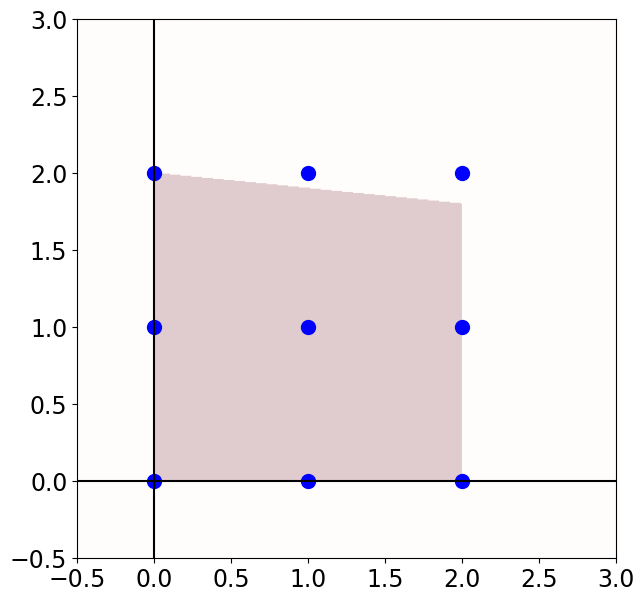

In [3]:

fig,ax = plt.subplots(figsize=(7,7))
ax.axhline(y=0, color = "black")
ax.axvline(x=0, color = "black")

# draw the region defind by x >= 0 and Ax <= b. 
ax.imshow(Z,
          extent=(X.min(),X.max(),Y.min(),Y.max()),
          origin="lower", 
          cmap="Reds", 
          alpha = 0.2)

def dot(x,y):
    return ax.scatter(x,y,s=100,color="blue")

# draw the integer points
for i,j in itertools.product(range(3),range(3)):
    dot(i,j)


You might imagine that the optimal *integer* solution is just obtained by rounding. Note the following:

$(2,2)$ is infeasible.

$(2,1)$ is feasible and $f(2,1) = 2 + 5\cdot 1 = 7$

$(1,2)$ is infeasible

$(1,1)$ is feasible and $f(1,1) = 1 + 5 \cdot 1 = 6$

But as it turns out, the optimal integer solution is the point $(0,2)$ for which $f(0,2) = 0 + 5 \cdot 2 = 10$.

Of course, this optimal integral solution is nowhere near the optimal non-integral solution. So in general, rounding is inadequate!

-------

How to proceed? Well, in this case there are not very many integral feasible points, so to optimize, we can just check the value of $f$ at all such points!

Consider a linear program in standard form for $\mathbf{x} \in \mathbb{R}^n$ with $\mathbf{x} \ge \mathbf{0}$, with inequality constraint $A \mathbf{x} \le \mathbf{b}$ which seeks to ``maximize`` its objective function $f$.



Here is a systematic way that we might proceed:

Find an integer $M \ge 0$ with the property that $$\mathbf{x} > M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix} \implies \text{$\mathbf{x}$ is infeasible}.$$

There are $(M+1)^n$ points $\mathbf{x}$ with integer coordinates for which $\mathbf{0} \le \mathbf{x} \le M \begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}$.

For each of these points $\mathbf{x}$, we do the following:
- if $\mathbf{x}$ is infeasible, discard
- otherwise, record the pair $(\mathbf{x},f(\mathbf{x}))$.

When we are finished, we just scan the list of recorded pairs and select that with  the largest objective function value; this selection solves the problem.



The strategy just described is systematic, easy to describe, and works OK when $(M+1)^n$ isn't so large. But e.g. if $M = 3$ and $n=20$, then already
$$(M+1)^n \approx 1.1 \times 10^{12},$$ 
which gives us a huge number of points to check!!!

A more efficient approach: "Branch & Bound"
============================================

We are going to describe an algorithm that implements a [branch-and-bound strategy](https://en.wikipedia.org/wiki/Branch_and_bound) to approach the problem described above.

Let's fix some notation; after we formulate some generalities, we'll specialize our treatment to some examples.



Notation
--------

We consider an ``integer linear program``:

$(\clubsuit)$ ``maximize`` $f(\mathbf{x}) = \mathbf{c}\cdot \mathbf{x}$

subject to:

- $\mathbf{x} \in \mathbb{Z}^n, \mathbf{x} \ge \mathbf{0}$ 
- $A \mathbf{x} \le \mathbf{b}$ for some $A \in \mathbb{R}^{r \times n}$ and $\mathbf{b} \in \mathbb{R}^r$.

Recall that $\mathbb{Z} = \{0, \pm 1, \pm 2, \cdots\}$ is the set of *integers*, and  $\mathbb{Z}^n$ is the just the set of vectors $\begin{bmatrix} a_1 & a_2 & \cdots & a_n \end{bmatrix}^T$ where $a_1,a_2, \dots, a_n \in \mathbb{Z}$.



We are going to suppose that we have some vector 

$$\mathbf{M} = \begin{bmatrix} m_1 & m_2 & \cdots & m_n \end{bmatrix}^T \in \mathbb{Z}^n, \quad \mathbf{M} \ge \mathbf{0}$$ 

with the property that $\mathbf{x} > \mathbf{M} \implies \mathbf{x}$ is infeasible (i.e. $\mathbf{x} > \mathbf{M} \implies A \mathbf{x} > \mathbf{b}$).

In practice, it'll often be the case that $m_1 = m_2 = \cdots = m_n$ but that isn't a requirement for us.

Let's write

$$S = \{ \mathbf{x} \in \mathbb{Z}^n \mid \mathbf{0} \le \mathbf{x} \le \mathbf{M} \}.$$ 

Note that the number of elements $|S|$ in the set $S$ is given by the product 
$$S = \prod_{i=1}^n (m_i + 1) = (m_1 + 1) \times (m_2 + 1) \times \cdots \times (m_n + 1).$$


And according to our assumption, $S$ contains every feasible point $\mathbf{x}$ whose coordinates are integers. So a brute force approach to finding an optimal integral point $\mathbf{x}$ could
be achieved just by testing each element of $S$.

Our goal is to systematically eliminate many of the points in $S$.

Algorithm overview
------------------

Keep the preceding notations. We sometimes refer to the entries $x_i$ of $\mathbf{x}$ as "variables".

Let's focus on one entry of $\mathbf{x} = \begin{bmatrix} x_1 & x_2 & \cdots & x_n \end{bmatrix}^T \in \mathbb{Z}^n$, say the $j$-th entry for some $1 \le j \le n$ (we'll say more below about how we should select $j$).  i.e. we focus on the variable $x_j$.

Now, $x_j$ may take the values $0,1,2,\cdots,m_j$, so we consider
the following subsets of $S$:

$$\begin{matrix} 
S_0 &=& \{\mathbf{x} \in S \mid x_j = 0\} \\
S_1 &=& \{\mathbf{x} \in S \mid x_j = 1\} \\
\vdots & \vdots & \vdots \\
S_{m_j} & = & \{\mathbf{x} \in S \mid x_j = m_j\}
\end{matrix}$$
 
Thus we have *partitioned* $S$ as a *disjoint union* of certain subsets:

$$S = S_0 \cup S_1 \cup \cdots \cup S_{m_j}$$



For $0 \le \ell \le m_j$, write $f_\ell$ for the maximum value of the objective function on points in $S_\ell$:


$$f_\ell = \max\left( f(\mathbf{x}) \mid \mathbf{x} \in S_\ell\right )=\max\left(\mathbf{c} \cdot \mathbf{x} \mid \mathbf{x} \in S_\ell\right ).$$

If we know for some $\ell_0$ that the quantity $f_{\ell_0}$ exceeds $f_\ell$ for every $\ell \not = \ell_0$, then of course an optimal integral 
to $(\clubsuit)$ is contained in the subset $S_{\ell_0}$.

So we can then *prune* all the $S_\ell$ with $\ell \not = \ell_0$ and continue our search for optimal solutions to $(\clubsuit)$ only considering points in $S_{\ell_0}$.

We may now *repeat* the above procedure by focusing on a *new entry of $\mathbf{x}$* (different from the $j$-th entry), checking only points in $S_{\ell_0}$.

Iterating after selection of the subset $S_{\ell_0}$ is known as *branching*.

The main question now is this: how can we compare the values $f_\ell, 0 \le \ell \le m_j$ with one another, in order to carry out our pruning? This is known as *bounding*; so the question is: "how do we bound"?

The answer is to use "relaxed" versions of the integer linear program $(\clubsuit)$, obtained by omitting variables (imposing additional equality constraints) and/or eliminating the "integral" requirement.

E.g. using ordinary linear programming, we may find the optimal *value* $v_\ell$ of the objective function for the linear program obtained from $(\clubsuit)$ by considering $\mathbf{x} \in \mathbb{R}^n$ rather than $\in \mathbb{Z}^n$ and
by imposing the additional equality constraint $x_j = \ell$.

Then of course $f_\ell \le v_\ell$ -- i.e. $v_\ell$ is an *upper bound* for $f_\ell$.

On the other hand, for any point $\mathbf{\widetilde x} \in S_\ell$, the must have 
$$f(\widetilde x) = \mathbf{c} \cdot \mathbf{\widetilde x} \le f_\ell$$
(since $f_\ell$ is the maximum of such values!).

These observations give us access to upper and lower bounds for the $f_\ell$; we can now *bound* - i.e. prune - $S_\ell$ if we can demonstrate that a lower bound for $f_{\ell_0}$ exceeds an upper bound for $f_\ell$
for $\ell \not = \ell_0$.


Example
-------------------

Let's see how this works in practice!

As a guiding heuristic, when we have a (non-integral) optimal point for a linear program, we choose
to branch on the variable whose value (for this optimal point) is non-integral but closest to a integer.

Consider again  the integer linear program

$(\diamondsuit) \quad $ ``maximize`` $f(x_0,x_1) = x_0 + 5x_1$; i.e. $\mathbf{c} \cdot \mathbf{x}$ where $\mathbf{c} = \begin{bmatrix} 1 & 5 \end{bmatrix}$.

such that $A \mathbf{x} = \begin{bmatrix} 1 & 10 \\ 1 & 0 \end{bmatrix} \begin{bmatrix} x_0 \\ x_1 \end{bmatrix} \le
\begin{bmatrix} 20 \\ 2 \end{bmatrix}$ and $\mathbf{x} \ge \mathbf{0}$ for $\mathbf{x} \in \mathbb{Z}^2$.

We notice that $(*) \quad \mathbf{x} > \begin{bmatrix} 2 & 2 \end{bmatrix}^T \implies \mathbf{x}$ is not feasible.

To begin, we first solve the linear program obtained from $(\diamondsuit)$ by considering $\mathbf{x} \in \mathbb{R}^2$. 

We are going to re-use this linear program repeatedly, so we create a `dictionary` describing it, as follows:

In [4]:
import numpy as np

def sbv(index,size):
    return np.array([1.0 if i == index else 0.0 for i in range(size)])

lp = { "goal": "maximize",
       "obj": np.array([1,5]),
       "Aub": np.array([[1,10],[1,0]]),
       "bub": np.array([20,2]),
       "bounds": 2*[(0,None)]
     }



In [5]:

result = linprog((-1)*lp["obj"] ,bounds = lp["bounds"], A_ub = lp["Aub"], b_ub = lp["bub"])

print(f"The optimal value is v = {abs(result.fun)} and an optimal solution is {result.x}")

The optimal value is v = 11.0 and an optimal solution is [2.  1.8]



Thus for this optimal solution, $x_0$ is already an integer, so we branch on $x_1$.

Now, we can have to consider 



Let's take a minute to write some code for branching.



In [6]:


def branch(specs,lp):
    n = len(lp["obj"])

    # create equality constraints for the "specs"
    # each spec is a dictionary {"index": i, "value": v}
    #
    Aeq = np.array([sbv(spec["index"],n) for spec in specs])
    beq = np.array([spec["value"] for spec in specs]) 

 
    #print(Aeq,beq)
    if lp["goal"] == "maximize":
        result = linprog((-1)*lp["obj"], 
                         bounds = lp["bounds"], 
                         A_ub=lp["Aub"], 
                         b_ub=lp["bub"], 
                         A_eq = Aeq, 
                         b_eq = beq)
    else:
        result = linprog(lp["obj"],  
                         bounds = lp["bounds"],
                         A_ub=lp["Aub"], 
                         b_ub=lp["bub"], 
                         A_eq = Aeq, 
                         b_eq = beq)

    if result.success:
        return {"obj_value": (-1)*result.fun,
                "solution": result.x}
    else:
        return "lin program failed"

Now we branch on `x1`. Recall that -- according to $(*)$ -- we need only consider values of `x1` in `[0,1,2]`.

In [7]:
[ (v,branch([{"index":1, "value": v}],lp)) for v in [0,1,2]]


[(0, {'obj_value': 2.0, 'solution': array([ 2., -0.])}),
 (1, {'obj_value': 7.0, 'solution': array([2., 1.])}),
 (2, {'obj_value': 10.0, 'solution': array([-0.,  2.])})]

Recall that -- in the notation used above -- `fi` denotes the maximum value of the objective function on points having
`x1 == i`.  The preceding calculation shows that

- `f0 <= 2`
- `f1 <= 7`
- since `[0,2]` is an integral solution, `10 <= f2`

This shows that `f2` exceeds both `f0` and `f1`, so we `prune` the sets $S_0$ and $S_1$.


We also see that $f_0 \le 2, f_1 \le 7$ and (since $(0,2)$ is an integral solution) $10 \le f_1$;
thus $f_1$ exceeds $f_0$ and $f_1$. Thus we ``prune`` $S_0$ and $S_1$.

Moreover, 
since the optimal solution $x1 == 2$ is actually integral, we find $f_2 = 10$.

Thus $f_2 = 10$ is the optimal value for $(\diamondsuit)$ and an optimal integral solution is `x = [0,2]`.


One often presents this algorithm via a tree diagram, like the following:

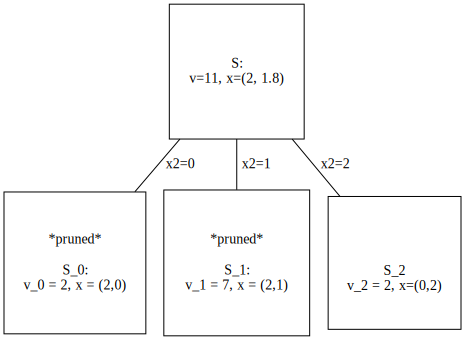

In [8]:
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')

dot.node('S','S:\nv=11, x=(2, 1.8)',shape="square")

dot.node('S0','*pruned*\n\nS_0:\nv_0 = 2, x = (2,0)',shape="square")
dot.node('S1','*pruned*\n\nS_1:\nv_1 = 7, x = (2,1) ',shape="square")
dot.node('S2','\n\nS_2\nv_2 = 2, x=(0,2)',shape="square")


dot.edge('S','S0','x2=0')
dot.edge('S','S1','x2=1')
dot.edge('S','S2','x2=2')

dot

--------------------
Now let's consider a more elaborate example.

Example
=======

$(\heartsuit) \quad $ ``maximize`` $f(\mathbf{x}) = \begin{bmatrix} 10 & 7 & 4 & 3 & 1 & 0 \end{bmatrix} \cdot \mathbf{x}$

subject to: $\mathbf{x} = \begin{bmatrix} x_1 & x_2 & x_3 & x_4 &x_5 & x_6 \end{bmatrix}^T \in \mathbb{R}^5$, $\mathbf{x} \ge \mathbf{0}$, 

$x_1,x_2,x_3,x_4,x_5 \in \{0,1\}$

and $A \mathbf{x} \le \mathbf{b}$

where $A = \begin{bmatrix}
 2 & 6 & 1 & 0 & 0 & 1 \\
 1 & 0 & 2 & -3 & 1 & -1 \\
 2 & -3 & 4 & 1 & 1 & 0 \\
 1 & 1 & 1 & 1 & -1 & 0  \\
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
7 \\ -1 \\ 3 \\ 3
\end{bmatrix}.$



Notice that we *aren't* imposing any integral condition on $x_6$, but we require that $x_i \in \mathbb{Z}$ for $1 \le i \le 5$, and even more: these coordinates may only take the value $0$ or $1$.

The procedure described above can (with perhaps some minor adaptations) be applied to this problem, as we now describe. Note that -- unlike the previous example -- we will have to iterate our procedure. 

-------

We begin by formulating the linear program
which replaces the integrality condition 
$x_1,x_2,x_3,x_4,x_5 \in \{0,1\}$
with the condition $\begin{bmatrix} x_1 & x_2 & x_3 & x_4 &x_5 \end{bmatrix}^T \le \begin{bmatrix} 1 & 1 & 1 & 1 & 1\end{bmatrix}^T$ 


In [9]:

nlp = {"goal": "maximize",
       "obj": np.array([10,7,4,3,1,0]),
       "Aub": np.array([[2,6,1,0,0,1],
                        [1,0,2,-3,1,-1],
                        [2,-3,4,1,1,0],
                        [1,1,1,1,-1,0]]),
       "bub": np.array([7,-1,3,3]),
       "bounds": 5*[(0,1)] + [(0,None)]
      }


Solving this linear program yields the following:

In [10]:
## A 

res= linprog((-1)*nlp["obj"],
             bounds = nlp["bounds"],
             A_ub = nlp["Aub"], 
             b_ub = nlp["bub"])

resA = { 'obj_value': abs(res.fun),
         'solution': res.x
       }
print(resA)


{'obj_value': 20.209302325581397, 'solution': array([1.        , 0.72093023, 0.48837209, 1.        , 0.20930233,
       0.18604651])}


We are going to label this solution **(A)** 

Of the non-integer coordinates of the solution `x` to **(A)**, the one closest to an integer is `x4 = 0.21`.
(Remember that we don't impose an integrality condition on `x5`!!)

We now **Branch on (A)** with `x4`:

We label **(B)** the result of setting ``x4==0``:

In [11]:
## B

resB =  branch([{"index": 4, "value": 0}],nlp)
resB

{'obj_value': 19.44444444444445,
 'solution': array([ 1.        ,  0.77777778,  0.33333333,  0.88888889, -0.        ,
         0.        ])}


And we label **(C)** the result of setting `x4==1`

In [12]:
## C

resC = branch([{"index": 4, "value": 1}],nlp)
resC

{'obj_value': 19.96969696969697,
 'solution': array([1.        , 0.6969697 , 0.27272727, 1.        , 1.        ,
        0.54545455])}


We must now branch off of both **(B)** and **(C)**. 

We'll begin with **(C)** and branch on `x2`

**(D)** will be the result of branching from **(C)** with `x2==0`:

In [13]:
## D

resD = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 0}],nlp)

resD

{'obj_value': 19.833333333333336,
 'solution': array([ 1.        ,  0.83333333, -0.        ,  1.        ,  1.        ,
         0.        ])}

**(E)** will be the result of branching from **(C)** with `x2==1`

In [14]:
## E

resE = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 1}],nlp)

resE

'lin program failed'

This branching failed because there are no feasible points.
So we may **Prune** **(E)**.


We now branch on **(D)** with `x1`

**F** will be the result of branching on **(D)** with `x1==0`:

In [15]:
## F

resF = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 0},
               {"index": 1, "value": 0}],nlp)

resF

{'obj_value': 11.0, 'solution': array([ 1., -0.,  0., -0.,  1.,  3.])}

Note that **(F)** gives an integral solution, so we can stop examining this branch of the tree.


**(G)** will be the result of branching on **(D)** with `x1==1`:

In [16]:
## G

resG = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 0}, 
               {"index": 1, "value": 1}],nlp)

resG

{'obj_value': 16.0, 'solution': array([0.5, 1. , 0. , 1. , 1. , 0. ])}

We now return and **branch on (B)** with `x4`:

**(H)** will be the result of branching on **(B)** with `x3==0`:

In [17]:
## H

resH = branch([{"index": 4, "value": 0},
               {"index":3, "value": 0}],nlp)

resH

{'obj_value': 13.727272727272727,
 'solution': array([ 1.        ,  0.27272727,  0.45454545, -0.        ,  0.        ,
         2.90909091])}

**(I)** will be the result of branching on **(B)** with `x3==1`:

In [18]:
## I

resI = branch([{"index": 4, "value": 0},
               {"index":3, "value": 1}],nlp)

resI

{'obj_value': 19.4, 'solution': array([ 1. ,  0.8,  0.2,  1. , -0. ,  0. ])}


Now **branch on (I)** with `x1`:


**(J)** will be the result of branching from **(I)** with `x1=0`.


In [19]:
## J

resJ = branch([{"index": 4, "value": 0},
               {"index":3, "value": 1},
               {"index":1, "value": 0}],nlp)

resJ

{'obj_value': 13.0, 'solution': array([ 1., -0., -0.,  1., -0.,  0.])}

The solution **(J)** is an integer point, and the objective value $13$ is larger than the objective value in **(F)**,
so we **Prune (F)**.

**(K)** will be the result of branching from **(I)** with `x1=1`:


In [20]:
## K

resK = branch([{"index": 4, "value": 0},
               {"index":3, "value": 1},
               {"index": 1, "value": 1}],nlp)

resK

{'obj_value': 15.0, 'solution': array([ 0.5,  1. ,  0. ,  1. , -0. ,  0. ])}

Now **branch from (G)** with $x_1$:

**(L)** will be the result of branching from **(G)** with `x0=0`


In [21]:
## L

resL = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 0}, 
               {"index": 1, "value": 1},
               {"index": 0, "value": 0}],nlp)

resL

{'obj_value': 11.0, 'solution': array([-0.,  1., -0.,  1.,  1.,  0.])}


This is an integer solution, so we **prune (L)** since the integer solution from **(J)** has an larger  objective function value than 11.

**(M)** is the result of branching from **(G)** with $x_0=1$


In [22]:
## M

resM = branch([{"index": 4, "value": 1}, 
               {"index": 2, "value": 0}, 
               {"index": 1, "value": 1},
               {"index": 0, "value": 1}],nlp)

resM

'lin program failed'

The linear program **(M)** is infeasible.




Finally, **branch from (K)** with $x_1$

**(N)** is the result of branching from **(K)** with `x0=0`:

In [23]:
## N 


resN = branch([{"index": 4, "value": 0},
               {"index":3, "value": 1},
               {"index": 1, "value": 1},
               {"index": 0, "value": 0}],nlp)

resN

{'obj_value': 14.0, 'solution': array([-0.,  1.,  1.,  1., -0.,  0.])}

**(N)** gives an integer solution.

**(O)** is the result of branching from **(K)** with `x0=1`:

In [24]:
## O


resO = branch([{"index": 4, "value": 0},
               {"index":3, "value": 1},
               {"index": 1, "value": 1},
               {"index": 0, "value": 1}],nlp)
resO

'lin program failed'

This linear program is infeasible.

Finally,we **Prune (H) and (J)** since the objective function for the point in **(N)** exceeds an upper bound for the objective functions in **(H)** and in **(J)**. 

We are now **finished**; the integer solution from **(N)**

`{'obj_value': 14.0, 'solution': array([-0.00, 1.00, 1.00, 1.00, -0.00, 0.00])}`

is an optimal point for $(\heartsuit)$.

-------------

We now construct (via ``graphviz``) the *tree* corresponding to the branch-and-bound just carried out; see below.


In [25]:
resE

'lin program failed'

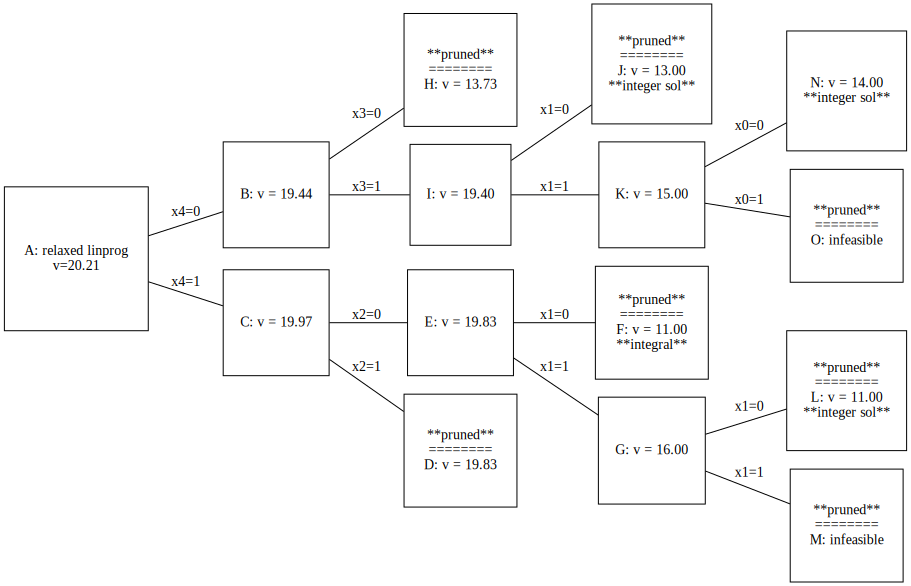

In [27]:
from graphviz import Graph

## https://www.graphviz.org/
## https://graphviz.readthedocs.io/en/stable/index.html

dot = Graph('bb1')
dot.attr(rankdir='LR')
dot.node('A',f"A: relaxed linprog\nv={resA['obj_value']:.2f}",shape="square")

dot.node('B',f"B: v = {resB['obj_value']:.2f}",shape="square")
dot.node('C',f"C: v = {resC['obj_value']:.2f}",shape="square")
dot.node('D',f"E: v = {resD['obj_value']:.2f}",shape="square")
dot.node('E',f"**pruned**\n========\nD: v = {resD['obj_value']:.2f}",shape="square")
dot.node('F',f"**pruned**\n========\nF: v = {resF['obj_value']:.2f}\n**integral**",shape="square")
dot.node('G',f"G: v = {resG['obj_value']:.2f}",shape="square")
dot.node('H',f"**pruned**\n========\nH: v = {resH['obj_value']:.2f}",shape="square")
dot.node('I',f"I: v = {resI['obj_value']:.2f}",shape="square")
dot.node('J',f"**pruned**\n========\nJ: v = {resJ['obj_value']:.2f}\n**integer sol**",shape="square")
dot.node('K',f"K: v = {resK['obj_value']:.2f}",shape="square")
dot.node('L',f"**pruned**\n========\nL: v = {resL['obj_value']:.2f}\n**integer sol**",shape="square")
dot.node('M','**pruned**\n========\nM: infeasible',shape="square")
dot.node('N',f"N: v = {resN['obj_value']:.2f}\n**integer sol**",shape="square")
dot.node('O','**pruned**\n========\nO: infeasible',shape="square")


dot.edge('A','B','x4=0')
dot.edge('A','C','x4=1')

dot.edge('B','H','x3=0')
dot.edge('B','I','x3=1')

dot.edge('C','D','x2=0')
dot.edge('C','E','x2=1')

dot.edge('D','F','x1=0')
dot.edge('D','G','x1=1')

dot.edge('G','L','x1=0')
dot.edge('G','M','x1=1')

dot.edge('I','J','x1=0')
dot.edge('I','K','x1=1')


dot.edge('K','N','x0=0')
dot.edge('K','O','x0=1')



dot

Postcript
=========

It turns out that solving integer programming problems is *hard*. In fact, in computer
science integer programming problems are in a class of problems called [**NP Hard** problems](https://en.wikipedia.org/wiki/NP-completeness) -- see the [discussion here.](https://en.wikipedia.org/wiki/Integer_programming).

The algorithm we describe above is a type of ``branch and bound algorithm``, which is a common approach. While our description gives pretty good evidence that this approach is effective, we haven't said anything e.g. about the ``run time`` of our algorithm, etc.